In [7]:

import numpy as np
import scipy as sp
from astropy.io import fits as pyfits
from astropy.table import Table
#from desispec.interpolation import resample_flux
#from desitarget.targetmask import desi_mask
#import desispec.io
#import sys
import os
import matplotlib.pyplot as plt


In [13]:
####  Catalog cutter

file = '/work3/desi_lya/data/eBOSS/dr15_all/DR14Q_v4_4.fits' # Add here the filename, include the full path if necesary
output = '/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits'
hdul = pyfits.open(file)
data = hdul[1].data
hdul.info()

# Nor: Origina size, Nnew: new size for the catalog (in overall items)
Nor = len(data)
Nnew = 600

# Random Mask of Nnew items from the Nor items of the orignal catalog
w = np.random.choice(Nor,Nnew,replace=False)

if os.path.exists(output):
  os.remove(output)

# Mask set in the catalog
hdul[1].data = data[w]
hdul.writeto(output)   # change name to the desired one.
hdul.close()
print('\n\nDone writing.\n')


hdul = pyfits.open( output )
data = hdul[1].data
hdul.info()
hdul.close() 
print('\nDone with final size= ', len(data) )


Filename: /work3/desi_lya/data/eBOSS/dr15_all/DR14Q_v4_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8   
  1  DR14Q_v4_4    1 BinTableHDU    328   526356R x 105C   ['18A', 'D', 'D', 'J', 'I', 'J', 'I', '4A', 'D', 'D', '4A', 'D', 'D', 'D', 'I', 'D', 'D', 'D', 'K', 'K', 'K', 'K', 'K', 'K', 'I', 'I', 'I', '51J', '51J', '51J', '51A', 'D', 'D', 'I', 'A', 'I', 'I', 'A', '5D', '5D', '5D', '5D', 'D', '5D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'D', 'D', 'D', 'D', 'D', 'D', 'E', 'I', 'D', 'D', 'E', 'I', 'D', 'D', 'E', 'I', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', '4A', '4A', 'D', 'E', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'I', 'D', 'D', 'D']   


Done writing.

Filename: /work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8   
  1  DR14Q_v4_

In [218]:
#### Catalog loading and mask example:

catalog=Table.read('/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits')
w=(catalog['THING_ID']>0) & (catalog['Z']>2) & (catalog['Z']<4) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
reduced_cat=catalog[w]

# Final reduced_cat size:
print(( np.sum(w) ))
print( len(reduced_cat) )


255
255


In [4]:

#####################################
# Load QSO from plates
### Parameters
path_spec      = '/work3/desi_lya/data/eBOSS/dr15_all/spplates'
path_drq       = '/work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits'

# for line correction (later)
#path_lines     = '/work3/desi_lya/data/eBOSS/dr12_all/dr16-line-sky-mask.txt'

zmin = 2
zmax = 4

# eBoss Catalog load, beginning of function
catalog = Table.read(path_drq)

w = (catalog['THING_ID']>0) & (catalog['Z'] > zmin ) & (catalog['Z']< zmax ) & (catalog['RA']!=catalog['DEC'])& (catalog['RA']>0) & (catalog['DEC']>0)
reduced_cat = catalog[w]
reduced_cat = reduced_cat.group_by('PLATE')

# thing_id = reduced_cat['THING_ID']
fiberid = reduced_cat['FIBERID']
plate = reduced_cat['PLATE']
zqso = reduced_cat['Z']
DEC = reduced_cat['DEC']
RA = reduced_cat['RA']

plate_list=[]
for p,m in zip(reduced_cat['PLATE'],reduced_cat['MJD']):
    plate_list.append(str(p)+'/spPlate-'+str(p)+'-'+str(m)+'.fits')
plate_list=np.unique(plate_list)

#thisplate=plate_list[0].split("/")[1]  # Location
#thisplate=plate_list[0].split("/")[0]  # Plate Number
print('Found '+ str(  np.sum(w) ) + ' QSO spec. in catalog: '+ path_drq )

spectra = []
QSOloc = []

## begin for test
for nplate in range ( 0, len(plate_list) ):
    plate1=pyfits.open( path_spec+'/'+plate_list[nplate].split("/")[1] )
    thisplate=plate_list[nplate].split("/")[0]  # Plate Number

    wp = plate == int( thisplate )
    ids_=fiberid[wp]
    zqso_=zqso[wp]
    DEC_ = DEC[wp]
    RA_ = RA[wp]

    nqsoPlate_= ids_.shape[0]
    print( str(nplate) + ': Loading '+ str(nqsoPlate_) +' QSO spec. from plate: '+ plate_list[nplate].split("/")[1] )
    # Reading data from plate
    plugmap = plate1['PLUGMAP'].data
    # Searching for fiber of qso in data
    wp = np.in1d(plugmap['FIBERID'],ids_)
    # Applying mask to select only QSO
    small_plugmap = plugmap[wp]

    #Get the spectra
    flux=plate1[0].data
    #Get the weight
    ivar=plate1[1].data

    #Get the wavelenght
    pltheader=plate1[0].header
    coeff0=pltheader['COEFF0']
    coeff1=pltheader['COEFF1']
    logwave=coeff0+coeff1*np.arange(flux.shape[1])

    for i in range(0,nqsoPlate_):

        w_ = (10**logwave)/(1+zqso_[i])
        w_crop = ( w_ >= 1040 ) & ( w_ <= 1215.67 )
        w_ = w_[w_crop]
        flx = flux[ids_[i]-1][w_crop]
        ivr = ivar[ids_[i]-1][w_crop]

        QSOloc.append( np.hstack(( zqso_[i], DEC_[i], RA_[i] )) )
        s=np.vstack( ( w_.conj().transpose(), flx.conj().transpose(), ivr.conj().transpose() ) )
        spectra.append( s )



Found 255 QSO spec. in catalog: /work/sfbeltranv/DR14_mini/DR14Q_v4_4m.fits
0: Loading 1 QSO spec. from plate: spPlate-3673-55178.fits
1: Loading 1 QSO spec. from plate: spPlate-3695-55212.fits
2: Loading 1 QSO spec. from plate: spPlate-3756-55505.fits
3: Loading 1 QSO spec. from plate: spPlate-3764-55514.fits
4: Loading 1 QSO spec. from plate: spPlate-3829-55300.fits
5: Loading 1 QSO spec. from plate: spPlate-3855-55268.fits
6: Loading 1 QSO spec. from plate: spPlate-3860-55269.fits
7: Loading 1 QSO spec. from plate: spPlate-3862-55276.fits
8: Loading 2 QSO spec. from plate: spPlate-3876-55245.fits
9: Loading 1 QSO spec. from plate: spPlate-3942-55338.fits
10: Loading 1 QSO spec. from plate: spPlate-3958-55329.fits
11: Loading 1 QSO spec. from plate: spPlate-3972-55589.fits
12: Loading 1 QSO spec. from plate: spPlate-3973-55323.fits
13: Loading 1 QSO spec. from plate: spPlate-3977-55335.fits
14: Loading 1 QSO spec. from plate: spPlate-3986-55329.fits
15: Loading 1 QSO spec. from plate

135: Loading 1 QSO spec. from plate: spPlate-5882-56029.fits
136: Loading 1 QSO spec. from plate: spPlate-5975-56334.fits
137: Loading 1 QSO spec. from plate: spPlate-5979-56329.fits
138: Loading 1 QSO spec. from plate: spPlate-5983-56310.fits
139: Loading 1 QSO spec. from plate: spPlate-6005-56090.fits
140: Loading 1 QSO spec. from plate: spPlate-6006-56105.fits
141: Loading 1 QSO spec. from plate: spPlate-6019-56074.fits
142: Loading 1 QSO spec. from plate: spPlate-6027-56103.fits
143: Loading 1 QSO spec. from plate: spPlate-6038-56090.fits
144: Loading 1 QSO spec. from plate: spPlate-6058-56090.fits
145: Loading 1 QSO spec. from plate: spPlate-6124-56211.fits
146: Loading 1 QSO spec. from plate: spPlate-6138-56598.fits
147: Loading 1 QSO spec. from plate: spPlate-6142-56219.fits
148: Loading 1 QSO spec. from plate: spPlate-6158-56239.fits
149: Loading 1 QSO spec. from plate: spPlate-6162-56191.fits
150: Loading 1 QSO spec. from plate: spPlate-6193-56237.fits
151: Loading 1 QSO spec.

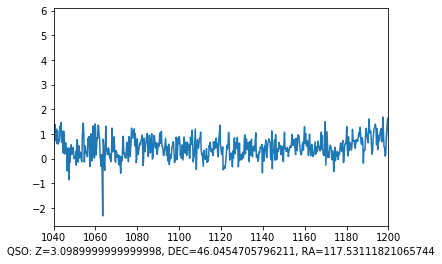

In [5]:
#### One QSO ploting example

nspectra = 0
s = spectra[ nspectra ]
z, dec, ra = QSOloc[nspectra]
plt.figure()
plt.plot( s[0], s[1] )
plt.xlim(1040,1200)
plt.xlabel( 'QSO: Z=' + str( z) + ', DEC=' + str( dec) +', RA=' + str( ra)  )
plt.show()